In [109]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms

In [110]:
# Setting up device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [111]:
# Setting up transforms from data
train_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [112]:
# Downloading the data and creating the dataset.
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [125]:
import os

# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
LR = 1e-3 # 1e-4 in the paper. Doing this for faster convergence.
EPOCHS = 25

# Creating the dataloader from the dataset
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [126]:
class_names = train_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [127]:
# Checking image shape and dtype
img, label = next(iter(trainloader))
img.shape, img.dtype, label.shape, label.dtype

(torch.Size([32, 3, 227, 227]), torch.float32, torch.Size([32]), torch.int64)

In [128]:
# Creating the model
class AlexNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_blocks = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=4, stride=4),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(3, 2),
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=9216, out_features=4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=4096, out_features=4096),
        nn.ReLU(),
        nn.Linear(in_features=4096, out_features=10),
    )

  def forward(self, x):
    return self.classifier(self.conv_blocks(x))

In [129]:
# Creating an instance of our model
alexnet = AlexNet().to(device)

In [130]:
# Checking if image can pass through model
logits = alexnet(img.to(device))
logits.shape

torch.Size([32, 10])

In [131]:
# Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# The paper uses SGD with Momentum.
# optimizer = optim.SGD(alexnet.parameters(),
#                       lr=LR, momentum=0.9)
optimizer = optim.Adam(alexnet.parameters(), lr=LR)

In [132]:
# Import torchmetrics for accuracy
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

In [133]:
import torchmetrics
# Training Helper Function
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accobj: torchmetrics.Accuracy,
               device: torch.device = None):

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (img, label) in enumerate(dataloader):

    if batch%100==0:
      print(f"Looked at batch: [{batch}/{len(dataloader)}]")

    # Move data to target device
    img = img.to(device)
    label = label.to(device)

    # Forward pass
    logits = model(img)

    # Loss
    loss = loss_fn(logits, label)
    train_loss += loss

    # Accuracy
    preds = torch.softmax(logits, dim=1).argmax(dim=1)
    acc = accobj(preds.cpu(), label.cpu())
    train_acc += acc

    # Set gradients to zero
    optimizer.zero_grad()

    # Backprop on loss
    loss.backward()

    # Update parameters
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.3f} | ", end='')

  return train_loss.item(), train_acc.item()

In [134]:
# Testing Helper Function
def test_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accobj: torchmetrics.Accuracy,
               device: torch.device = None):

  test_loss, test_acc = 0, 0

  # Put model in testing mode
  model.eval()
  with torch.inference_mode():
    for batch, (img, label) in enumerate(dataloader):

      # Move image and label to target device
      img, label = img.to(device), label.to(device)

      # Forward pass
      logits = model(img)

      # Loss
      loss = loss_fn(logits, label)
      test_loss += loss

      # Accuracy
      preds = torch.softmax(logits, dim=1).argmax(dim=1)
      acc = accobj(preds.cpu(), label.cpu())
      test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    print(f"Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}")

  return test_loss.item(), test_acc.item()

In [135]:
### Training and Testing
from tqdm.auto import tqdm

def learn(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          accobj: torchmetrics.Accuracy,
          device: torch.device = None):

  train_loss, train_acc = [], []
  test_loss, test_acc = [], []

  for epoch in tqdm(range(epochs)):

    print(f"Epoch: [{epoch+1}/{epochs}]\n-----------")

    loss, acc = train_step(model, train_dataloader, loss_fn, optimizer, accobj, device)
    train_loss.append(loss)
    train_acc.append(acc)

    loss, acc = test_step(model, test_dataloader, loss_fn, accobj, device)
    test_loss.append(loss)
    test_acc.append(acc)

  return train_loss, train_acc, test_loss, test_acc

In [136]:
accobj = Accuracy(task='multiclass', num_classes=10)

trainloss, trainacc, testloss, testacc = learn(alexnet, trainloader, testloader, loss_fn, optimizer, EPOCHS, accobj, device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: [1/25]
-----------
Looked at batch: [0/1563]
Looked at batch: [100/1563]
Looked at batch: [200/1563]
Looked at batch: [300/1563]
Looked at batch: [400/1563]
Looked at batch: [500/1563]
Looked at batch: [600/1563]
Looked at batch: [700/1563]
Looked at batch: [800/1563]
Looked at batch: [900/1563]
Looked at batch: [1000/1563]
Looked at batch: [1100/1563]
Looked at batch: [1200/1563]
Looked at batch: [1300/1563]
Looked at batch: [1400/1563]
Looked at batch: [1500/1563]
Train Loss: 1.82406 | Train Acc: 0.309 | Test Loss: 1.53210 | Test Acc: 0.433
Epoch: [2/25]
-----------
Looked at batch: [0/1563]
Looked at batch: [100/1563]
Looked at batch: [200/1563]
Looked at batch: [300/1563]
Looked at batch: [400/1563]
Looked at batch: [500/1563]
Looked at batch: [600/1563]
Looked at batch: [700/1563]
Looked at batch: [800/1563]
Looked at batch: [900/1563]
Looked at batch: [1000/1563]
Looked at batch: [1100/1563]
Looked at batch: [1200/1563]
Looked at batch: [1300/1563]
Looked at batch: [1400/1

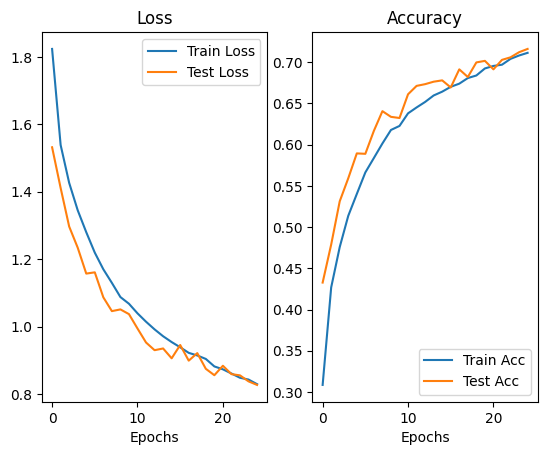

In [137]:
# Plotting the loss and accuracy curves of the model
import matplotlib.pyplot as plt

n_epochs = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(n_epochs, trainloss, label='Train Loss')
plt.plot(n_epochs, testloss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(n_epochs, trainacc, label='Train Acc')
plt.plot(n_epochs, testacc, label='Test Acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();